In [ ]:
!nvidia-smi


Thu Jan  4 14:41:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2,ResNet50

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:


IMAGE_SIZE = 256
EPOCHS = 30
BATCH = 8
LR = 1e-4

PATH ="/content/drive/MyDrive/OTU_2D"

In [ ]:

def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "annotations/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0


    (thresh, x) = cv2.threshold(x, 0, 1, cv2.THRESH_BINARY)

    x = np.expand_dims(x, axis=-1)


    return x

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=seed)

    self.augumet = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal_and_vertical"),tf.keras.layers.RandomRotation(0.2),])

  def call(self, inputs, labels):
    inputs = self.augumet(inputs)
    labels = self.augumet(labels)
    return inputs, labels

In [ ]:

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    # dataset= dataset.map(Augment())
    return dataset

In [ ]:

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_y))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  1177
Validation data:  146
Testing data:  146


In [ ]:

train_dataset = tf_dataset(train_x, train_y, batch=BATCH)

valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)


MODEL

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from keras.models import Model
from keras.layers import Input, Concatenate, Conv2D, MaxPooling2D
def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x
def SPPF_module(x,k= 5):
  B,H,W,C = x.shape
  cv1 = Conv2D(C//2, (1,1), strides=(1,1), padding = 'valid')(x)
  cv1 = BatchNormalization()(cv1)
  cv1= tf.nn.silu(cv1)
  mp1 = MaxPooling2D(pool_size=(k, k), strides=(1, 1), padding='same')(cv1)
  mp2 = MaxPooling2D(pool_size=(k, k), strides=(1, 1), padding='same')(mp1)
  mp3 = MaxPooling2D(pool_size=(k, k), strides=(1, 1), padding='same')(mp2)
  out = Concatenate(axis=-1)([cv1,mp1,mp2,mp3])
  out = Conv2D(C, (1,1), strides=(1,1), padding = 'valid')(out)
  out = BatchNormalization()(out)
  out= tf.nn.silu(out)
  return out
def build_vgg16_attention_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output
    # s1 = SPPF_module(s1,k= 5)
    s2 = vgg16.get_layer("block2_conv2").output
    # s2 = SPPF_module(s2,k= 5)
    s3 = vgg16.get_layer("block3_conv3").output
    # s3 = SPPF_module(s3,k= 5)
    s4 = vgg16.get_layer("block4_conv3").output
    # s4 = SPPF_module(s4,k= 5)
    b1 = vgg16.get_layer("block5_conv3").output
    b1 = SPPF_module(b1,k= 5)
    """ Bridge """
    # b1 = vgg19.get_layer("block5_conv4").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model
input = (256,256,3)
model = build_vgg16_attention_unet(input)
model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                             

In [ ]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")

    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    f = [16, 32, 48, 64]
    #f = [32, 64, 128, 256]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)
    return model
model = model()

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x
def build_vgg16_attention_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output
    s2 = vgg16.get_layer("block2_conv2").output
    s3 = vgg16.get_layer("block3_conv3").output
    s4 = vgg16.get_layer("block4_conv3").output
    b1 = vgg16.get_layer("block5_conv3").output

    """ Bridge """
    # b1 = vgg19.get_layer("block5_conv4").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model
input = (256,256,3)
model = build_vgg16_attention_unet(input)
model.summary()

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def attention_unet(input_shape):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512)

    """ Decoder """
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Outputs """
    outputs = L.Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model

if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = attention_unet(input_shape)
    model.summary()


In [ ]:
from keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, AveragePooling2D
from keras.layers import GlobalAveragePooling2D, Concatenate, Input, Reshape
from keras.models import Model
from keras.applications.resnet import ResNet50
from keras.applications import VGG19


def Pyramid_Pooling_Module(features, f=64, p1=2, p2=3, p3=6):

    shape = features.shape
    red = GlobalAveragePooling2D()(features)
    red = Reshape((1,1,shape[-1]))(red)
    red = Conv2D(filters=f, kernel_size=(1,1), padding='same', use_bias=False)(red)
    red = BatchNormalization()(red)
    red = Activation('relu')(red)
    red = UpSampling2D(size=shape[1],interpolation='bilinear')(red)

    orange = AveragePooling2D(pool_size=(p1))(features)
    orange = Conv2D(filters=f, kernel_size=(1,1), padding='same', use_bias=False)(orange)
    orange = BatchNormalization()(orange)
    orange = Activation('relu')(orange)
    orange = UpSampling2D(size=p1,interpolation='bilinear')(orange)

    blue = AveragePooling2D(pool_size=(p2))(features)
    blue = Conv2D(filters=f, kernel_size=(1,1), padding='same', use_bias=False)(blue)
    blue = BatchNormalization()(blue)
    blue = Activation('relu')(blue)
    blue = UpSampling2D(size=p2,interpolation='bilinear')(blue)

    green = AveragePooling2D(pool_size=(p3))(features)
    green = Conv2D(filters=f, kernel_size=(1,1), padding='same', use_bias=False)(green)
    green = BatchNormalization()(green)
    green = Activation('relu')(green)
    green = UpSampling2D(size=p3,interpolation='bilinear')(green)

    return Concatenate()([features, red, orange, blue, green])


def PSPNet(inputs, classes=1):

    inputs = Input(inputs)

    base_model = VGG19(weights='imagenet', include_top=False, input_tensor=inputs)
    base_model_features = base_model.get_layer('block4_conv4').output

    x = Pyramid_Pooling_Module(base_model_features, f=64, p1=2, p2=4, p3=8)

    x = Conv2D(filters=512, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D(interpolation='bilinear')(x)
    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D(interpolation='bilinear')(x)
    x = Conv2D(filters=128, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D(interpolation='bilinear')(x)
    x = Conv2D(filters=64, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)



    """ Outputs """
    x = Conv2D(classes, (1, 1), name='output_layer')(x)

    if classes == 1:
      x = Activation('sigmoid')(x)
    else:
      x = Activation('softmax')(x)

    model = Model(inputs=inputs, outputs=x)

    return model
model = PSPNet((256,256,3),1)
model.summary()

In [ ]:
import tensorflow as tf
from keras.layers import*
def PAM_module(x):
  gamma = tf.Variable(tf.ones(1))
  x_origin = x
  print(x)
  B, H, W, C = x.shape
  query = Conv2D(kernel_size=1,filters= C // 8, padding = 'same')(x)
  key = Conv2D(kernel_size=1,filters= C // 8, padding = 'same')(x)
  value = Conv2D(kernel_size=1,filters= C, padding = 'same')(x)
  query , key , value = tf.transpose(query, [0,3,1,2]), tf.transpose(key, [0,3,1,2]), tf.transpose(value, [0,3,1,2])
  key = tf.reshape(key, (-1, C//8, H*W))
  query = tf.transpose(tf.reshape(query, (-1, C//8, H*W)), [0,2,1])
  energy = tf.matmul(query, key)
  attention = tf.nn.softmax(energy)
  value = tf.reshape(value, (-1, C, H*W))
  out = tf.matmul(value,tf.transpose(attention, [0,2,1]))
  out = tf.reshape(out, [-1, C, H, W])
  out = tf.transpose(out, [0,2,3,1])
  out = add([out*gamma, x_origin])
  return out

In [ ]:
def CAM_module(x):
  gamma = tf.Variable(tf.ones(1))
  x_origin = x
  B, H, W, C = x.shape
  x = tf.transpose(x, [0,3,1,2])
  query = tf.reshape(x,(-1, C, H*W) )
  key = tf.transpose(query, [0,2,1])
  energy = tf.matmul(query, key)
  # energy = query @ key
  energy_new = tf.reduce_max(energy, axis = -1, keepdims = True)
  energy_new = tf.repeat(energy_new, C, axis = -1)
  energy_new = energy_new - energy
  attention = tf.nn.softmax(energy_new)
  value = query
  out = tf.matmul(attention, value)
  # out = attention @ value
  out = tf.reshape(out, (-1, C, H, W))
  out = tf.transpose(out, [0,2,3,1])
  out = add([out*gamma , x_origin])
  return out

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from keras.models import Model
from keras.layers import Input, Concatenate, Conv2D, MaxPooling2D
def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x
def SPPF_module(x,k= 5):
  B,H,W,C = x.shape
  cv1 = Conv2D(C//2, (1,1), strides=(1,1), padding = 'valid')(x)
  cv1 = BatchNormalization()(cv1)
  cv1= tf.nn.silu(cv1)
  mp1 = MaxPooling2D(pool_size=(k, k), strides=(1, 1), padding='same')(cv1)
  mp2 = MaxPooling2D(pool_size=(k, k), strides=(1, 1), padding='same')(mp1)
  mp3 = MaxPooling2D(pool_size=(k, k), strides=(1, 1), padding='same')(mp2)
  out = Concatenate(axis=-1)([cv1,mp1,mp2,mp3])
  out = Conv2D(C, (1,1), strides=(1,1), padding = 'valid')(out)
  out = BatchNormalization()(out)
  out= tf.nn.silu(out)
  return out
def build_vgg16_attention_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output
    # s1 = SPPF_module(s1,k= 5)
    s2 = vgg16.get_layer("block2_conv2").output
    # s2 = SPPF_module(s2,k= 5)
    s3 = vgg16.get_layer("block3_conv3").output
    # s3 = SPPF_module(s3,k= 5)
    s4 = vgg16.get_layer("block4_conv3").output
    # s4 = SPPF_module(s4,k= 5)
    b1 = vgg16.get_layer("block5_conv3").output
    pam = PAM_module(b1)
    pam = Conv2D(512, 3, padding='same', use_bias=False, kernel_initializer='he_normal')(pam)
    pam = BatchNormalization(axis=3)(pam)
    pam = Activation('relu')(pam)
    pam = Dropout(0.1)(pam)
    pam = Conv2D(512, 1, padding='same', use_bias=False, kernel_initializer='he_normal')(pam)

    cam = CAM_module(b1)
    cam = Conv2D(512, 3, padding='same', use_bias=False, kernel_initializer='he_normal')(cam)
    cam = BatchNormalization(axis=3)(cam)
    cam = Activation('relu')(cam)
    cam = Dropout(0.1)(cam)
    cam = Conv2D(512, 1, padding='same', use_bias=False, kernel_initializer='he_normal')(cam)

    feature_sum = add([pam, cam])



    x = Conv2D(filters=512, kernel_size=1, padding='same', use_bias=False)(feature_sum)
    b1 = SPPF_module(x,k= 5)


    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model
input = (256,256,3)
model = build_vgg16_attention_unet(input)
model.summary()

NameError: name 'PAM_module' is not defined

In [ ]:
from keras.models import Model
import tensorflow as tf
from keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, BatchNormalization
def SPPF_module(x,k= 5):
  B,H,W,C = x.shape
  cv1 = Conv2D(C, (1,1), strides=(1,1), padding = 'valid')(x)
  cv1 = BatchNormalization()(cv1)
  cv1= tf.nn.silu(cv1)
  mp1 = MaxPooling2D(pool_size=(k, k), strides=(1, 1), padding='same')(cv1)
  mp2 = MaxPooling2D(pool_size=(k, k), strides=(1, 1), padding='same')(mp1)
  mp3 = MaxPooling2D(pool_size=(k, k), strides=(1, 1), padding='same')(mp2)
  out = Concatenate(axis=-1)([cv1,mp1,mp2,mp3])
  out = Conv2D(C, (1,1), strides=(1,1), padding = 'valid')(out)
  out = BatchNormalization()(out)
  out= tf.nn.silu(out)
  return out

In [ ]:
from hashlib import sha384
from keras.models import Model
from keras.layers import Input, Activation, Conv2D, Dropout
from keras.layers import MaxPooling2D, BatchNormalization
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import add
from tensorflow.keras.applications import VGG16


def build_DA_unet(input_shape, classes):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output
    s2 = vgg16.get_layer("block2_conv2").output
    s3 = vgg16.get_layer("block3_conv3").output
    s4 = vgg16.get_layer("block4_conv3").output
    b1 = vgg16.get_layer("block5_conv3").output
    b1 = SPPF_module(b1,k= 5)
    print(b1.shape)
    # b1 = Conv2D(512, 3, padding='same', use_bias=False, kernel_initializer='he_normal')(b1)
    # b1 = BatchNormalization(axis=3)(b1)
    # b1 = Activation('relu')(b1)
    pam = PAM_module(b1)
    print(b1.shape)
    pam = Conv2D(512, 3, padding='same', use_bias=False, kernel_initializer='he_normal')(pam)
    pam = BatchNormalization(axis=3)(pam)
    pam = Activation('relu')(pam)
    pam = Dropout(0.1)(pam)
    pam = Conv2D(512, 1, padding='same', use_bias=False, kernel_initializer='he_normal')(pam)

    cam = CAM_module(b1)
    cam = Conv2D(512, 3, padding='same', use_bias=False, kernel_initializer='he_normal')(cam)
    cam = BatchNormalization(axis=3)(cam)
    cam = Activation('relu')(cam)
    cam = Dropout(0.1)(cam)
    cam = Conv2D(512, 1, padding='same', use_bias=False, kernel_initializer='he_normal')(cam)

    feature_sum = add([pam, cam])

    # feature_sum = Dropout(0.2)(feature_sum)

    x = Conv2D(filters=512, kernel_size=1, padding='same', use_bias=False)(feature_sum)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)
    # x = Conv2D(filters=512, kernel_size=3, padding='same', use_bias=False)(feature_sum)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)
    # x = Dropout(0.1)(x)
    # x = Conv2D(filters=512, kernel_size=1, padding='same', use_bias=False)(feature_sum)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)
    # x = Dropout(0.1)(x)
    # x = Conv2D(filters=512, kernel_size=1, padding='same', use_bias=False)(feature_sum)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)


    # conv7 = Conv2d_BN(conv7, 512, 3)

    x = UpSampling2D(interpolation='bilinear')(x)
    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D(interpolation='bilinear')(x)
    x = Conv2D(filters=128, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D(interpolation='bilinear')(x)
    x = Conv2D(filters=64, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D(interpolation='bilinear')(x)
    x = Conv2D(filters=32, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(classes, (1, 1), name='output_layer')(x)

    if classes == 1:
      x = Activation('sigmoid')(x)
    else:
      x = Activation('softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model
model = build_DA_unet((256,256,3),1)
model.summary()


(None, 16, 16, 512)
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='tf.nn.silu_1/IdentityN:0', description="created by layer 'tf.nn.silu_1'")
(None, 16, 16, 512)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

LOSSES

In [ ]:
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy, BinaryCrossentropy

beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1e-15


def dice_coef( y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (
            K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity( y_true, y_pred):
    true_negatives = K.sum(
        K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def convert_to_logits(y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                              1 - tf.keras.backend.epsilon())
    return tf.math.log(y_pred / (1 - y_pred))

def weighted_cross_entropyloss(y_true, y_pred):
    y_pred = convert_to_logits(y_pred)
    pos_weight = beta / (1 - beta)
    loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred,
                                                    labels=y_true,

                                                    pos_weight=pos_weight)
    return tf.reduce_mean(loss)

def focal_loss_with_logits( logits, labels, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * labels
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - labels)

        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(

            -logits)) * (weight_a + weight_b) + logits * weight_b

def focal_loss( y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                              1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))

    loss = focal_loss_with_logits(logits=logits, labels=y_true,
                                        alpha=alpha, gamma=gamma, y_pred=y_pred)

    return tf.reduce_mean(loss)

def depth_softmax( matrix):
    sigmoid = lambda x: 1 / (1 + K.exp(-x))
    sigmoided_matrix = sigmoid(matrix)
    softmax_matrix = sigmoided_matrix / K.sum(sigmoided_matrix, axis=0)
    return softmax_matrix

def generalized_dice_coefficient( y_true, y_pred):
    #smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (
            K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss( y_true, y_pred):
    loss = 1 - generalized_dice_coefficient(y_true, y_pred)
    return loss
def focal_dice_loss( y_true, y_pred):
  loss = focal_loss(y_true, y_pred)+dice_loss(y_true, y_pred)
  return loss
def bce_dice_loss( y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + \
            dice_loss(y_true, y_pred)
    return loss / 2.0

def confusion( y_true, y_pred):
    #smooth = 1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    prec = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)
    return prec, recall

def true_positive(y_true, y_pred):
   # smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth) / (K.sum(y_pos) + smooth)
    return tp

def true_negative( y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth)
    return tn

def tversky_index( y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.3
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (
            1 - alpha) * false_pos + smooth)

def tversky_loss( y_true, y_pred):
    return 1 - tversky_index(y_true, y_pred)

def focal_tversky( y_true, y_pred):
    pt_1 = tversky_index(y_true, y_pred)
    gamma = 0.75
    return K.pow((1 - pt_1), gamma)

def log_cosh_dice_loss( y_true, y_pred):
    x = dice_loss(y_true, y_pred)
    return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

def jacard_similarity( y_true, y_pred):
    """
      Intersection-Over-Union (IoU), also known as the Jaccard Index
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum((y_true_f + y_pred_f) - (y_true_f * y_pred_f))
    return intersection / union


def jacard_loss(y_true, y_pred):
    """
      Intersection-Over-Union (IoU), also known as the Jaccard loss
    """
    return 1 - jacard_similarity(y_true, y_pred)

def ssim_loss(y_true, y_pred):
    """
    Structural Similarity Index (SSIM) loss
    """
    return 1 - tf.image.ssim(y_true, y_pred, max_val=1)

def unet3p_hybrid_loss(y_true, y_pred):
    """
    Hybrid loss proposed in UNET 3+ (https://arxiv.org/ftp/arxiv/papers/2004/2004.08790.pdf)
    """
    focal_loss1 = focal_loss(y_true, y_pred)
    ms_ssim_loss1 = ssim_loss(y_true, y_pred)
    jacard_loss1 = jacard_loss(y_true, y_pred)
    diceloss = dice_loss( y_true, y_pred)
    return (focal_loss1 + ms_ssim_loss1 + jacard_loss1)/3

def hybrid_loss( y_true, y_pred):
    bce_loss =binary_crossentropy(y_true, y_pred)
    dice_loss1 = dice_loss(y_true, y_pred)
    jacard_loss1 = jacard_loss(y_true, y_pred)
    return (bce_loss+ jacard_loss1+dice_loss1)/3


def binary_dice(y_true, y_pred): # xap xi hybrid_loss
    return 0.5 *binary_crossentropy(y_true, y_pred) + dice_loss( y_true, y_pred)#[0.22297033667564392, 0.7812317609786987, 0.6458732485771179, 0.8226447701454163, 0.7904954552650452]


def FocalLoss(y_true, y_pred):

    # alpha = 0.3
    # gamma = 2
    alpha = 0.26
    gamma = 2.3
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    inputs = K.flatten(y_pred)
    targets = K.flatten(y_true)

    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)

    return focal_loss
def joint_loss1(y_true, y_pred):
    focal_loss1 = FocalLoss(y_true, y_pred)
    ms_ssim_loss1 = ssim_loss(y_true, y_pred)
    jacard_loss1 = jacard_loss(y_true, y_pred)
    loss =  (focal_loss1 + ms_ssim_loss1 + jacard_loss1)/3
    return loss
def bce_loss(y_true, y_pred):
 return binary_crossentropy(y_true, y_pred)

In [ ]:

opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef,jacard_similarity, Recall(), Precision()]

model.compile(loss=focal_loss,optimizer=opt, metrics=metrics)

In [ ]:

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    # ModelCheckpoint('/content/drive/MyDrive/ML/checkpoint2.weights.h5', save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)
]

In [ ]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

history=model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,

    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30
148/148 [==============================] - 414s 2s/step - loss: 0.0201 - dice_coef: 0.4082 - jacard_similarity: 0.2594 - recall: 0.5116 - precision: 0.8759 - val_loss: 0.0180 - val_dice_coef: 0.4065 - val_jacard_similarity: 0.2588 - val_recall: 0.6530 - val_precision: 0.8971 - lr: 1.0000e-04
Epoch 2/30
148/148 [==============================] - 104s 703ms/step - loss: 0.0134 - dice_coef: 0.4945 - jacard_similarity: 0.3304 - recall: 0.6725 - precision: 0.9211 - val_loss: 0.0173 - val_dice_coef: 0.5725 - val_jacard_similarity: 0.4057 - val_recall: 0.8362 - val_precision: 0.8176 - lr: 1.0000e-04
Epoch 3/30
148/148 [==============================] - 104s 702ms/step - loss: 0.0106 - dice_coef: 0.5554 - jacard_similarity: 0.3865 - recall: 0.7448 - precision: 0.9426 - val_loss: 0.0147 - val_dice_coef: 0.5714 - val_jacard_similarity: 0.4033 - val_recall: 0.8333 - val_precision: 0.8475 - lr: 1.0000e-04
Epoch 4/30
148/148 [==============================] - 104s 700ms/step - loss: 0.00

In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
model.evaluate(test_dataset, steps=test_steps)

19/19 [==============================] - 37s 2s/step - loss: 0.1330 - dice_coef: 0.8461 - jacard_similarity: 0.7373 - recall: 0.8292 - precision: 0.8843


[0.13304691016674042,
 0.8461310863494873,
 0.7373090982437134,
 0.829237163066864,
 0.8842952251434326]

In [ ]:
test_x[0]

'/content/drive/MyDrive/OTU_2D/images/1153.JPG'

In [ ]:
def read_image(path):
    # path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    print(path)
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    (thresh, x) = cv2.threshold(x, 0, 1, cv2.THRESH_BINARY)
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [ ]:
image = read_image(test_x[4])
image.shape

(256, 256, 3)

In [ ]:
def plot_chart(history):
    dice = history.history['dice_coef']
    val_dice = history.history['val_dice_coef']
    IoU= history.history['jacard_similarity']
    val_IoU = history.history['val_jacard_similarity']
    Recall= history.history['recall']
    val_recall = history.history['val_recall']
    Precision= history.history['precision']
    val_Precision = history.history['val_precision']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(dice))
    plt.figure(figsize=(10, 6))

    plt.plot(epochs, dice, 'r', label='Training dice')
    plt.plot(epochs, val_dice, 'b', label='Validation dice')
    plt.plot(epochs, IoU, 'maroon', label='jacard_similarity')
    plt.plot(epochs, val_IoU, 'orange', label='val_jacard_similarity')
    plt.plot(epochs, Recall, 'pink', label='recall')
    plt.plot(epochs, val_recall, 'brown', label='val_recall')
    plt.plot(epochs, Recall, 'violet', label='precision')
    plt.plot(epochs, val_recall, 'tan', label='val_precision')
    plt.plot(epochs, loss, 'g', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')

    plt.title('Metrics and Loss')
    plt.legend(loc=0)
    plt.show()

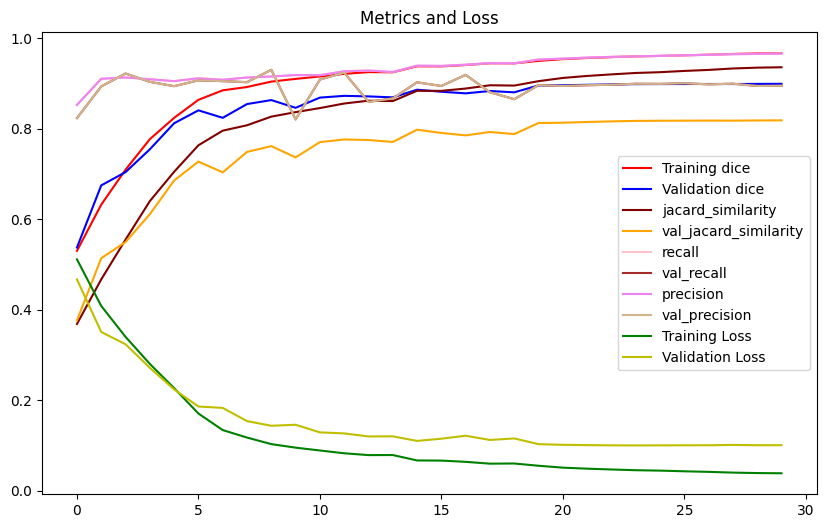

In [ ]:
plot_chart(history)

In [ ]:
def plot_chart(history):

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))
    plt.figure(figsize=(10, 6))
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.plot(epochs, loss, 'g', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')

    plt.title('model loss')
    plt.legend(loc=0)
    plt.show()

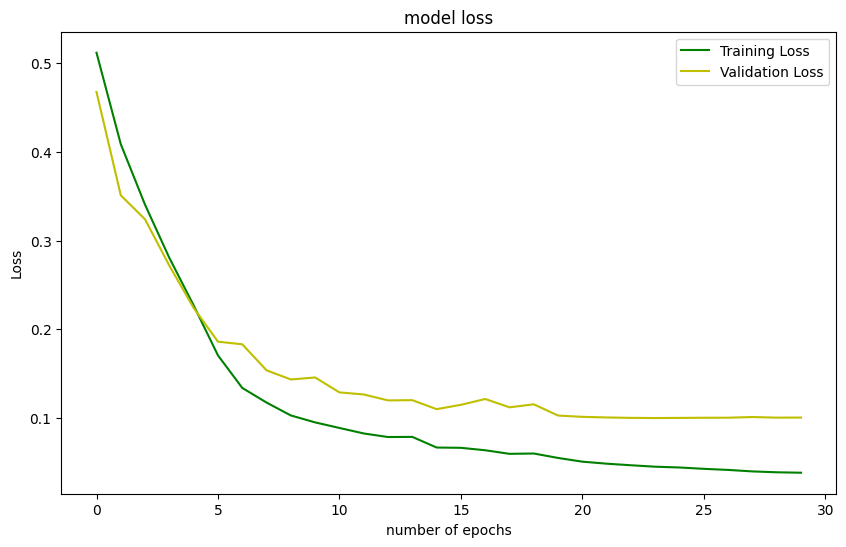

In [ ]:
plot_chart(history)

In [ ]:
def plot_chart(history):
    dice = history.history['dice_coef']
    val_dice = history.history['val_dice_coef']
    IoU= history.history['jacard_similarity']
    val_IoU = history.history['val_jacard_similarity']


    epochs = range(len(dice))
    plt.figure(figsize=(10, 6))
    plt.xlabel('number of epochs')
    plt.ylabel('metric')
    plt.plot(epochs, dice, 'r', label='Training dice')
    plt.plot(epochs, val_dice, 'b', label='Validation dice')
    plt.plot(epochs, IoU, 'maroon', label='jacard_similarity')
    plt.plot(epochs, val_IoU, 'orange', label='val_jacard_similarity')

    plt.title('Model Metrics')
    plt.legend(loc=0)
    plt.show()

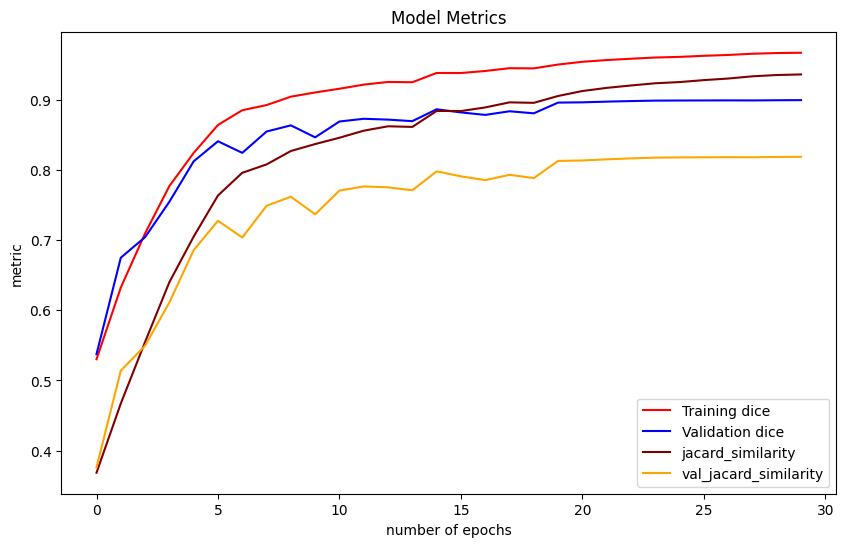

In [ ]:
plot_chart(history)

In [ ]:
model.save_weights('/content/drive/MyDrive/ML/AttentionUnet_SPPF_BCE_new.h5')

In [ ]:
def read_image(path):

    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    print(path)
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    (thresh, x) = cv2.threshold(x, 0, 1, cv2.THRESH_BINARY)
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [ ]:
for i in range(0,50):

    x = read_image(test_x[i])
    y = read_mask(test_y[i])
    model.load_weights('/content/drive/MyDrive/ML/focal_propose.h5')
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    model.load_weights('/content/drive/MyDrive/ML/AttentionUnet_SPPF_IOU_new.h5')
    y_pred1 = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    model.load_weights('/content/drive/MyDrive/ML/AttentionUnet_SPPF_jointloss.h5')
    y_pred2 = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    model.load_weights('/content/drive/MyDrive/ML/SSIM_propose.h5')
    y_pred3 = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    y=cv2.resize(read_and_rgb(test_y[i]), (IMAGE_SIZE, IMAGE_SIZE))

    fig, axes = plt.subplots(1,6,figsize= (12,12))
    axes[0].imshow(x,cmap = 'gray')
    axes[0].set_title('Original')
    axes[1].imshow(y, cmap = 'gray')
    axes[1].set_title('Label')
    axes[2].imshow(y_pred, cmap = 'gray')
    axes[2].set_title('Focal')
    axes[3].imshow(y_pred1,cmap ='gray')
    axes[3].set_title('IOU')
    axes[4].imshow(y_pred3,cmap ='gray')
    axes[4].set_title('SSIM')
    axes[5].imshow(y_pred2,cmap ='gray')
    axes[5].set_title('propose')
    for ax in axes:
        ax.axis('off')
    plt.show()

In [ ]:
for i in range(50,90):

    x = read_image(test_x[i])
    y = read_mask(test_y[i])

    model.load_weights('/content/drive/MyDrive/ML/AttentionUnet_SPPF_jointloss.h5')
    y_pred2 = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    y=cv2.resize(read_and_rgb(test_y[i]), (IMAGE_SIZE, IMAGE_SIZE))

    fig, axes = plt.subplots(1,3,figsize= (12,12))
    axes[0].imshow(x,cmap = 'gray')
    axes[0].set_title('Original')
    axes[1].imshow(y,cmap = 'gray')
    axes[1].set_title('label')
    axes[2].imshow(y_pred2,cmap ='gray')
    axes[2].set_title('Propose')
    # for ax in axes:
    #     ax.axis('off')

    # plt.show()
    contours1, _ = cv2.findContours((np.sum(y, axis=-1) > 0.5).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours4, _ = cv2.findContours((np.sum(y_pred2, axis=-1) > 0.5).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x = x.copy()
    for ax in axes:
        ax.axis('off')
    plt.show()